## Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

---
## First, I'll perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images

/Users/azheng/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Text(0.5,1,'HOG')

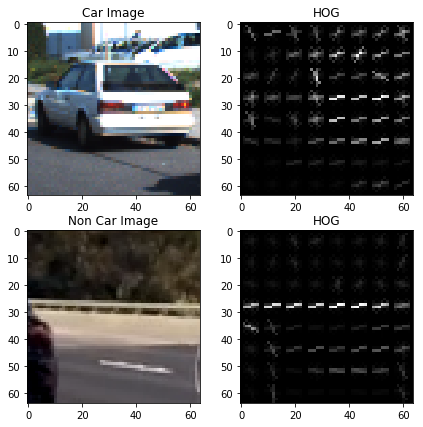

In [19]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from glob import glob
from skimage.feature import hog
%matplotlib inline


def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), 
                                   cells_per_block=(cell_per_block, cell_per_block),
                                   visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False,
                          visualise=vis, feature_vector=feature_vec)         
        return features    

# Read in the test image
#image = cv2.imread('vehicles/GTI_Far/image0000.png')    
#image = mpimg.imread('test_images/test1.jpg')
#cars = glob.glob('vehicles/*.png')
#not_cars = glob.glob('non-vehicles/*.png')

cars = []
start_dir = 'vehicles'
pattern   = "*.png"

for dir,_,_ in os.walk(start_dir):
    cars.extend(glob(os.path.join(dir,pattern)))

not_cars = []    
start_dir = 'non-vehicles'

for dir,_,_ in os.walk(start_dir):
    not_cars.extend(glob(os.path.join(dir,pattern)))

# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
car_image = mpimg.imread(cars[ind])
# Read in the image
non_car_image = mpimg.imread(not_cars[ind])

# convert to gray scale
gray_car = cv2.cvtColor(car_image, cv2.COLOR_RGB2GRAY)    
# convert to gray scale
gray_non_car = cv2.cvtColor(non_car_image, cv2.COLOR_RGB2GRAY)

# define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2

# Call our function with vis=True to see an image output
features, car_hog_image = get_hog_features(gray_car, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Call our function with vis=True to see an image output
features, non_car_hog_image = get_hog_features(gray_non_car, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)  

# Plot the examples
fig = plt.figure(figsize=(7,7))
plt.subplot(221)
plt.imshow(car_image, cmap='gray')
plt.title('Car Image')
plt.subplot(222)    
plt.imshow(car_hog_image, cmap='gray')
plt.title('HOG')
plt.subplot(223)
plt.imshow(non_car_image, cmap='gray')
plt.title('Non Car Image')
plt.subplot(224)    
plt.imshow(non_car_hog_image, cmap='gray')
plt.title('HOG')